# Training a Fully Connected Neural Network using Tensorflow

In [3]:
import os
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from cf_matrix import make_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

In [5]:
tf.__version__

'2.6.0'

## Loading Training Data

Currently, the data we have is unbalanced and future updates should improve on this.

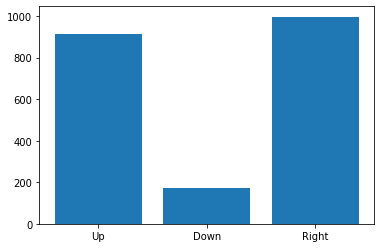

In [6]:
parent_dir = os.getcwd()
training_data_folder = os.path.join(parent_dir, "training_data")

up_folder = os.path.join(training_data_folder, "up")
down_folder = os.path.join(training_data_folder, "down")
right_folder = os.path.join(training_data_folder, "right")

up_images = os.listdir(up_folder)
down_images = os.listdir(down_folder)
right_images = os.listdir(right_folder)

up_count = len(up_images)
down_count = len(down_images)
right_count = len(right_images)

labels = ["Up","Down","Right"]
plt.bar(labels,[up_count, down_count, right_count])
plt.show()

## Preparing the Images for Training

Input Array Shape: (2080, 2400)
Label Array Shape: (2080,)


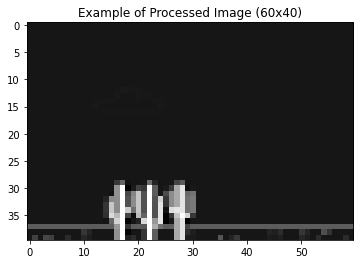

In [9]:
X = []
y = []

folder_list = [up_folder, down_folder, right_folder]

for curr_folder in folder_list:
    for image_name in os.listdir(curr_folder):
        label = image_name[:image_name.index("(")]

        image = cv.imread(os.path.join(curr_folder, image_name))
        grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        normalized = grayscale / 255
        resized = cv.resize(normalized, (60, 40), interpolation=cv.INTER_AREA)

        # Unrolling the matrices into vectors of 2400 pixels.
        X.append(np.ravel(resized))
        y.append(label)

X = np.array(X)
y = np.array(y)

plt.imshow(np.reshape(X[0], (40,60)), cmap="gray")
plt.title("Example of Processed Image (60x40)")

print("Input Array Shape:",X.shape)
print("Label Array Shape:",y.shape)

## Encoding the Categorical Labels (up, down and right) to One-Hot-Encoded

In [11]:
encoder = OneHotEncoder(categories=[["up", "down", "right"]])
y_encoded = np.array(encoder.fit_transform(y.reshape(-1,1)).toarray())

print(y_encoded[:5, :])
print(y_encoded.shape)


[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(2080, 3)


## Splitting the Dataset into Training and Test Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=True)

## Configuring the Network

In [14]:
model = tf.keras.models.Sequential()

# Hidden Layer
model.add(tf.keras.layers.Dense(units=100, input_shape=(2400,), activation="relu"))
# 3 output units, one for each of the possible keys to press.
model.add(tf.keras.layers.Dense(units=3, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               240100    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 240,403
Trainable params: 240,403
Non-trainable params: 0
_________________________________________________________________


## Compile and Train

In [17]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
52/52 [==============================] - 1s 3ms/step - loss: 1.1523 - accuracy: 0.5042
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 0.9263 - accuracy: 0.6166
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 0.9485 - accuracy: 0.6316
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.9349 - accuracy: 0.6460
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.8452 - accuracy: 0.6791
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.9031 - accuracy: 0.6575
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 0.8812 - accuracy: 0.6917
Epoch 8/100
52/52 [==============================] - 0s 2ms/step - loss: 0.8488 - accuracy: 0.6965
Epoch 9/100
52/52 [==============================] - 0s 2ms/step - loss: 0.8055 - accuracy: 0.7218
Epoch 10/100
52/52 [==============================] - 0s 3ms/step - loss: 0.8553 - accuracy: 0.7145
Epoch 11/

## Model Evaluation

13/13 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.8630
              precision    recall  f1-score   support

          Up       0.85      0.88      0.86       180
        Down       0.92      0.89      0.90        37
       Right       0.87      0.84      0.85       199

    accuracy                           0.86       416
   macro avg       0.88      0.87      0.87       416
weighted avg       0.86      0.86      0.86       416



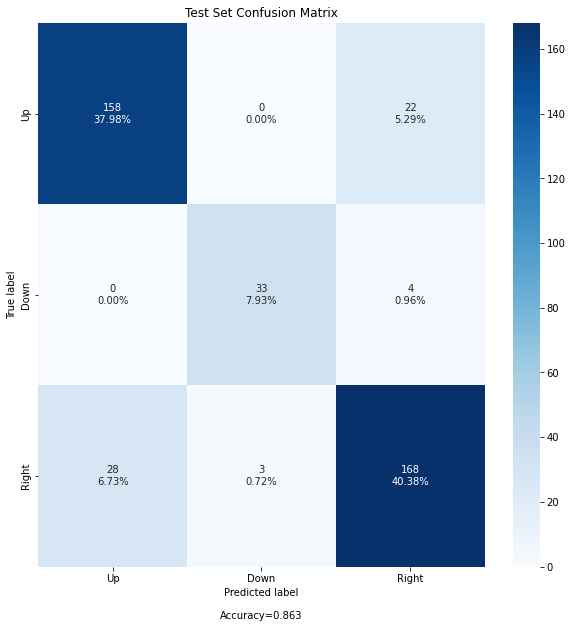

In [23]:
metrics = model.evaluate(X_test, y_test)

test_set_predictions = np.argmax(model.predict(X_test), axis=1)
original_test_output = np.argmax(y_test, axis=1)

test_report = classification_report(original_test_output, test_set_predictions, target_names=labels)
print(test_report)

matrix = confusion_matrix(original_test_output, test_set_predictions)
make_confusion_matrix(matrix, categories=labels, figsize=(10,10), title="Test Set Confusion Matrix")

## Exporting the Model

The main model which I find to be best performing is saved under "saved_model". Hence, at the current time, I don't want to overwrite this. Instead, the following cell will now prompt for a model name which will be saved under a folder called "test_models"

In [20]:
if "saved_model" not in os.listdir(parent_dir):
    os.mkdir(os.path.join(parent_dir, "saved_model"))
    model.save("saved_model")
    
else:
    if "test_models" not in os.listdir(parent_dir):
        os.mkdir(os.path.join(parent_dir, "test_models"))
    test_models_directory = os.path.join(parent_dir, "test_models")

    model_name = input("Enter the model name:")
    model.save(f"{test_models_directory}/{model_name}")

INFO:tensorflow:Assets written to: c:\Users\Naim\Desktop\Dev Work\MachineLearning\dinosaur-game-ai\test_models/test_model_7_Sept_v1\assets
